In [36]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression

In [37]:
data = pd.read_csv('/content/sp500.csv')
data['Date'] = pd.to_datetime(data['Date'])
data["% ^GSPC"] = data["^GSPC"].pct_change()

We create a percentage returns in index returns. We take the data from 1980 to 2023.
We Assume that the initial stage is bull market, because we want to measure from the first drop in 20% from base.


In [38]:
# Filter data from 1980-01-01 to 2023-12-31
filtered_data = data[(data['Date'] >= '1980-01-01') & (data['Date'] <= '2023-12-31')]

# Initialize tracking variables
market_phases = []   # To store the start and end dates of each market phase
current_phase = 'bull' #We assume the starting phase is bull market, because we want to measure the first drop in 20%, and change in base is similar to bull market
phase_start_date = None
base = filtered_data.iloc[0]['^GSPC']
last_peak = base

#Idenitifying the phases through iterations
for index, row in filtered_data.iterrows():
    current_date, current_index = row['Date'], row['^GSPC']

    if current_phase == 'bull':
        if current_index >= last_peak:
            last_peak = current_index   # Update peak in bull market
        elif current_index <= 0.8 * last_peak:
            market_phases.append((phase_start_date, current_date, 'bull'))  # Bull market ends, append phase
            current_phase = 'bear'
            phase_start_date = current_date   # Mark bear market start
            base = current_index   # Reset base for bear market
    else:
        if current_index < base:
            base = current_index   # Update base if lower value found in bear market
        elif current_index >= 1.2 * base:
            market_phases.append((phase_start_date, current_date, 'bear'))
            current_phase = 'bull'
            phase_start_date = current_date
            last_peak = current_index   # Reset peak for new bull market

# After the loop, check if the last phase needs to be appended
if phase_start_date is not None:
    # Append the ongoing phase at the end of the dataset
    market_phases.append((phase_start_date, filtered_data['Date'].iloc[-1], current_phase))

all_phases_df = pd.DataFrame(market_phases, columns=['Start Date', 'End Date', 'Phase'])
phases_df = all_phases_df[all_phases_df['Phase'] == 'bear'].reset_index(drop=True)   # Converts the phases list to a DataFrame

print(f"The List of bear markets since 1980: \n {phases_df}")

The List of bear markets since 1980: 
   Start Date   End Date Phase
0 1982-02-22 1982-09-14  bear
1 1987-10-19 1988-03-08  bear
2 2001-03-12 2001-12-05  bear
3 2002-07-10 2002-08-22  bear
4 2008-07-09 2008-12-08  bear
5 2009-02-23 2009-03-23  bear
6 2020-03-12 2020-04-08  bear
7 2022-06-13 2023-06-08  bear


Using our definition of bear market phases, we find 8 bear markets. We find that there is the largest expansion from 1987 to 2001. The latest bear market was in 2022, the tech market crash.

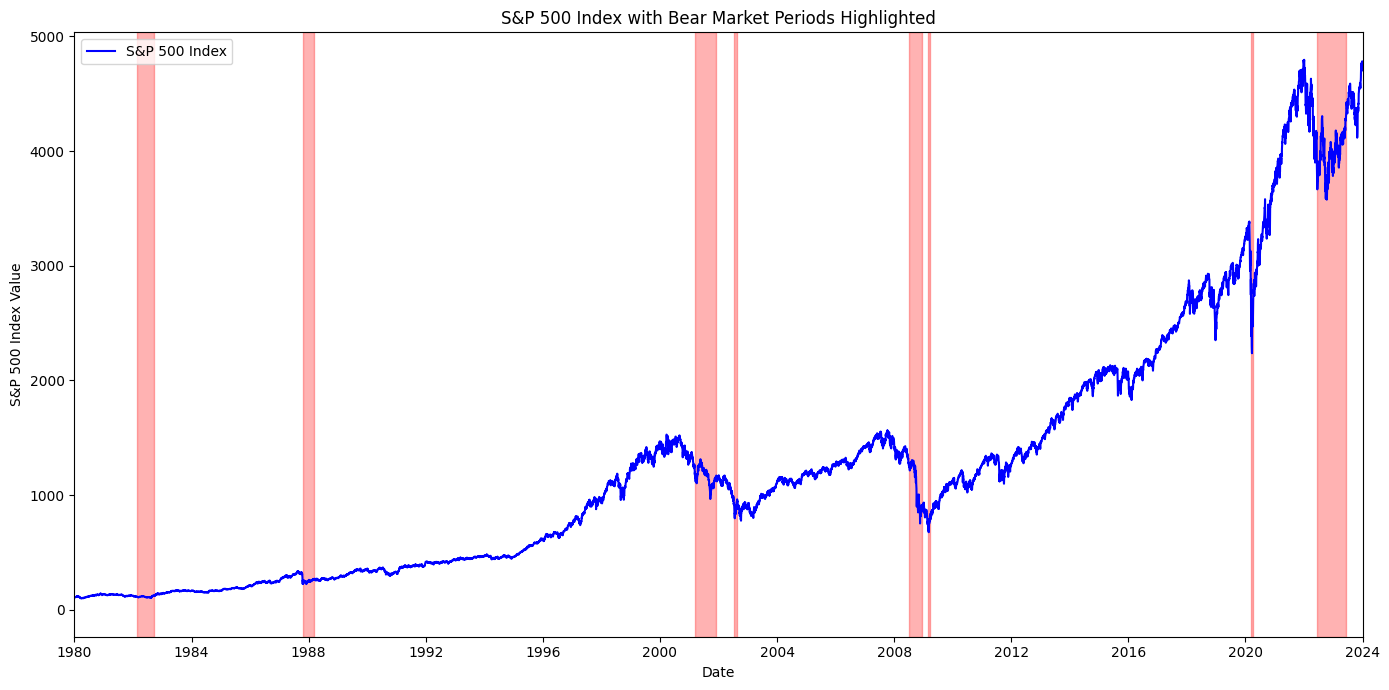

In [39]:
# Plot the S&P 500 index over time
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['^GSPC'], label='S&P 500 Index', color='blue')

# Highlight bear market durations
for start, end in phases_df.iterrows():
    plt.axvspan(end['Start Date'], end['End Date'], color='red', alpha=0.3) #red for bear market

ax = plt.gca()

#Plotting
plt.title('S&P 500 Index with Bear Market Periods Highlighted')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index Value')
plt.xlim(pd.Timestamp('1980'), pd.Timestamp('2024'))
plt.ylim(0, 5000)
plt.legend()

#Setting year parameters
ax.xaxis.set_major_locator(mdates.YearLocator(4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.grid(True)
plt.show()

In this graph, we can see that the largest bear market was in 2022. The shortest was in 2020, during the covid pandemic panic.

In [40]:
def extract_bear_market_data(main_df, start_date, end_date):
    return main_df[(main_df['Date'] >= start_date) & (main_df['Date'] <= end_date)].drop('^GSPC', axis=1)

bear_market_dfs = {}
#Making a list with only dataframes of only bear markets
for index, row in phases_df.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    key = f"{start_date.date()} to {end_date.date()}"
    bear_market_dfs[key] = extract_bear_market_data(filtered_data, start_date, end_date)

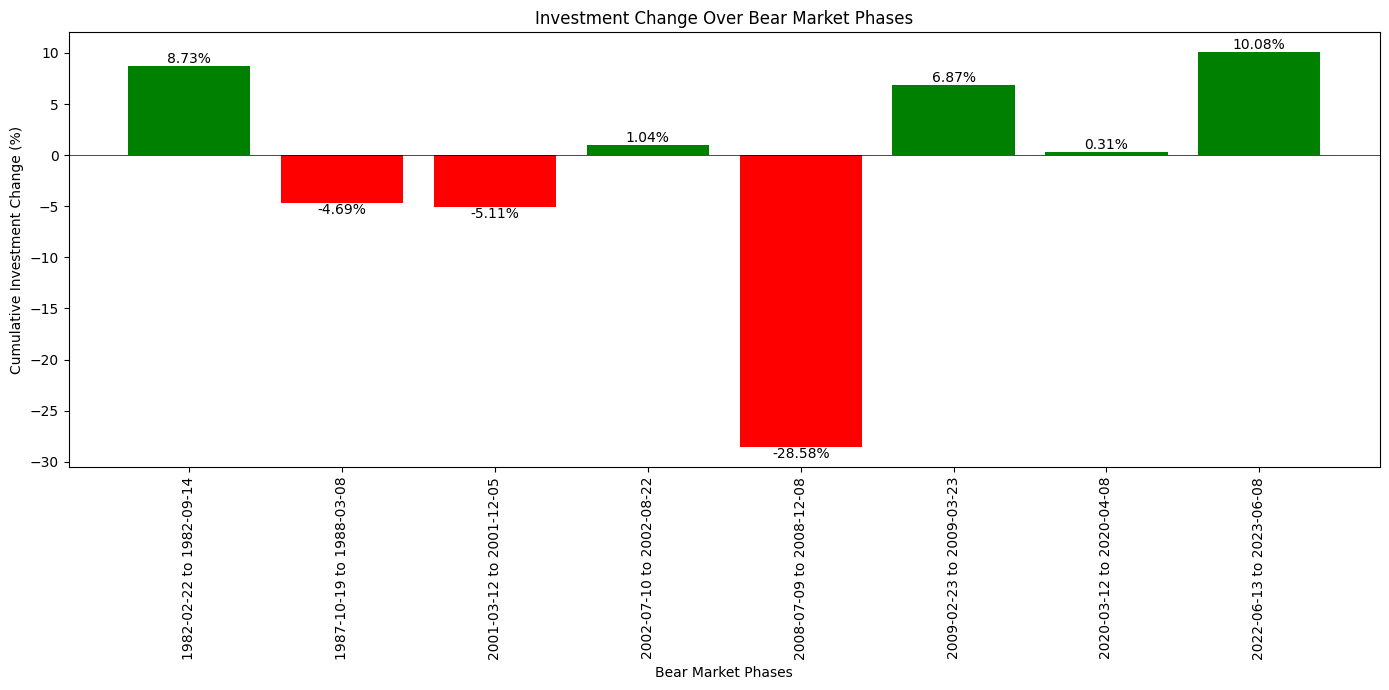

In [80]:
# Initialize a list to hold the final investment change for each phase
investment_changes = []
phases = []

# Calculate the investment change for each bear market phase
for key, df in bear_market_dfs.items():
    # Calculate the cumulative product to simulate investment value over time
    cumulative_product = (1 + df['% ^GSPC']).cumprod()
     # The investment change is the last value in the cumulative product series minus the initial investment
    investment_change = (cumulative_product.iloc[-1] - 1) * 100  # Convert to percentage change
    investment_changes.append(investment_change)
    phases.append(key)

# Plot the bar graph
plt.figure(figsize=(14, 7))
bars = plt.bar(phases, investment_changes, color=['red' if x < 0 else 'green' for x in investment_changes])

plt.xlabel('Bear Market Phases')
plt.ylabel('Cumulative Investment Change (%)')
plt.title('Investment Change Over Bear Market Phases')
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(rotation=90)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va=('bottom' if yval > 0 else 'top'))

plt.tight_layout()
plt.show()

In the above, we have measured the intensity of the bear markets to the investors. The 2022 bear market, which saw the tech crash still saw 10% returns on the market index. This could be due to the crash mainly affecting tech sector. The worst bear market was in 2008, coinciding with the housing bubble crash. This means that the market was broadly affected.

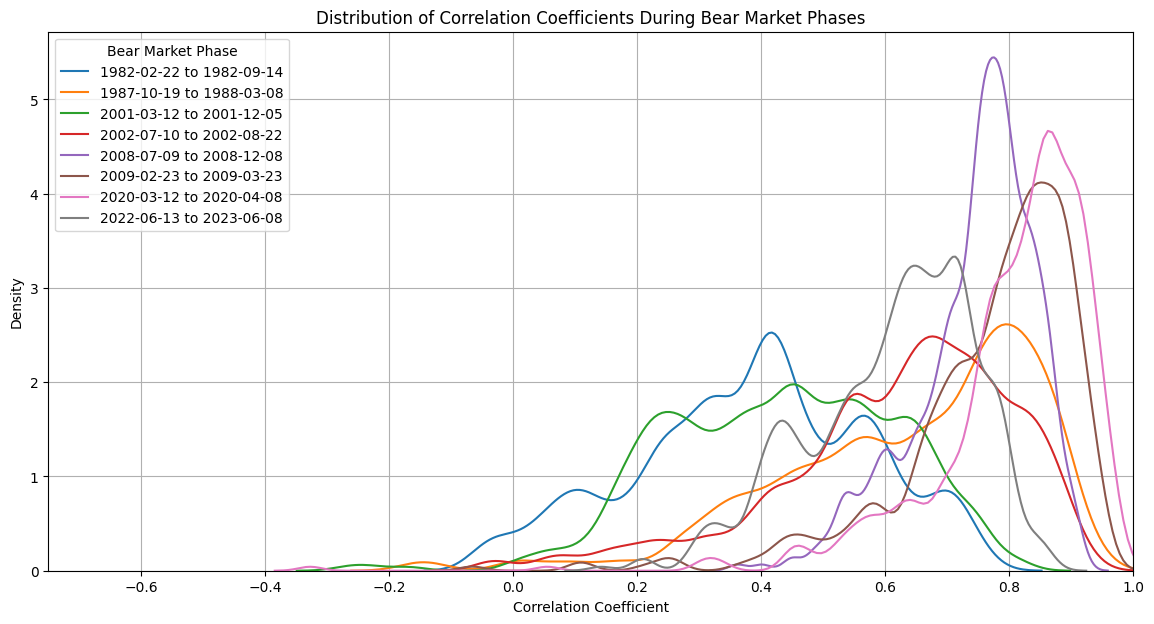

In [81]:
corr_index= {}

for key, bm_df in bear_market_dfs.items():
    corr_index[key] = bm_df.drop(columns=['% ^GSPC']).corrwith(bm_df['% ^GSPC'], numeric_only = True)

# Iterate through the corr_index and plot each phase's KDE on the same figure
plt.figure(figsize=(14, 7))
for key, corr_values in corr_index.items():
    sns.kdeplot(corr_values, bw_adjust=0.5, label=key)

plt.xlim(-0.75, 1)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Distribution of Correlation Coefficients During Bear Market Phases')
plt.legend(title='Bear Market Phase')
plt.grid(True)
plt.show()

In the above, we have made correlation of the stocks against the index during the bear markets. We can see that only in a few of the phases, the stocks on average tend to 1. Otherwise they are near 0.8. The highest correlation to 1 was in 2020. This maybe because the Pandemic affected the entire market as a whole.

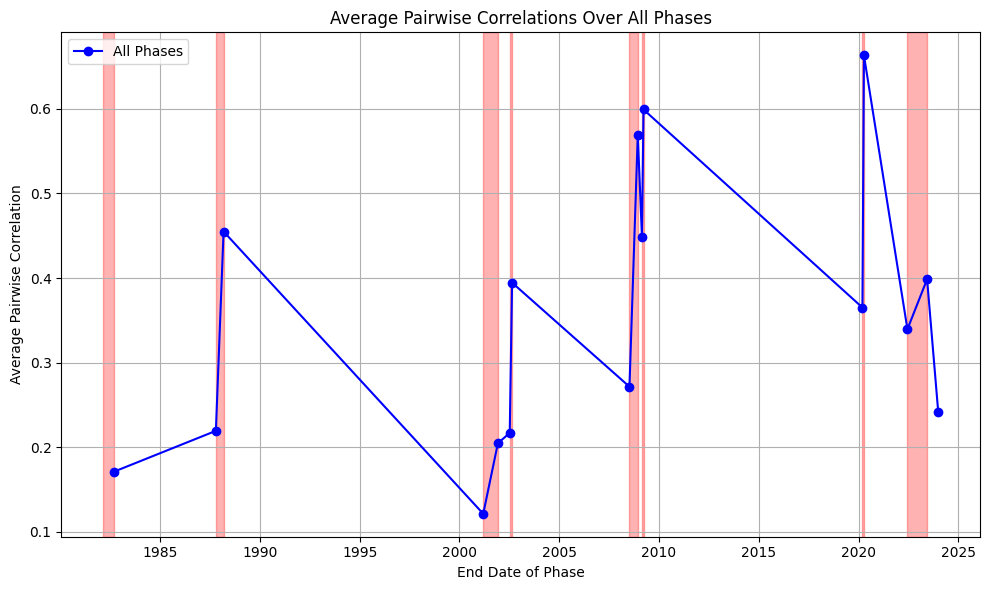

In [83]:
# Define function to calculate average pairwise correlation
def calculate_average_pairwise_correlation(df):
    corr_matrix = df.corr(numeric_only = True)
    # Use boolean indexing to select upper triangle of the matrix without the diagonal
    upper_tri_flat = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
    return upper_tri_flat.mean()

# Define function to extract market data
def extract_market_data(main_df, start_date, end_date):
    # Assuming '^GSPC' should be excluded for correlation calculation
    return main_df[(main_df['Date'] >= start_date) & (main_df['Date'] <= end_date)].drop(columns=['^GSPC'])

# Calculate correlations for all phases
all_phases_corrs = {
    phase['End Date']: calculate_average_pairwise_correlation(extract_market_data(filtered_data, phase['Start Date'], phase['End Date']))
    for _, phase in all_phases_df.iterrows()
}

# Plot for all phases
plt.figure(figsize=(10, 6))
dates = list(all_phases_corrs.keys())
correlations = list(all_phases_corrs.values())
plt.plot(dates, correlations, 'o-b', label='All Phases')
plt.title('Average Pairwise Correlations Over All Phases')

#HIghlighting ending of bear market avg pairwise correlation
for start, end in phases_df.iterrows():
    plt.axvspan(end['Start Date'], end['End Date'], color='red', alpha=0.3)

plt.xlabel('End Date of Phase')
plt.ylabel('Average Pairwise Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare DataFrame for bear market correlations
bear_correlations_data = {
    'End Date': [end_date for _, end_date in phases_df['End Date'].items()],
    'Average Correlation': [calculate_average_pairwise_correlation(df) for df in bear_market_dfs.values()]
}

bear_correlations_df = pd.DataFrame(bear_correlations_data)

In the above, we have calculated the average of pieciewise correlation among all the stocks across the different phases. In the graph we can see the average piecewise correlation in bear markets was 0.7 in the 2020 crash, one which affected every firm equally. Otherwise correlations are not close to 1.

In [85]:
bear_correlations_df['Average Correlation'].describe()

count    8.000000
mean     0.431954
std      0.178513
min      0.171188
25%      0.347052
50%      0.426797
75%      0.576644
max      0.663352
Name: Average Correlation, dtype: float64

If we take summary stats of piecewiswe correlations of the bear markets as a whole, we can see that the median is only 0.42, and highest is 0.66. The volatality of the correlations is also high at 0.17.

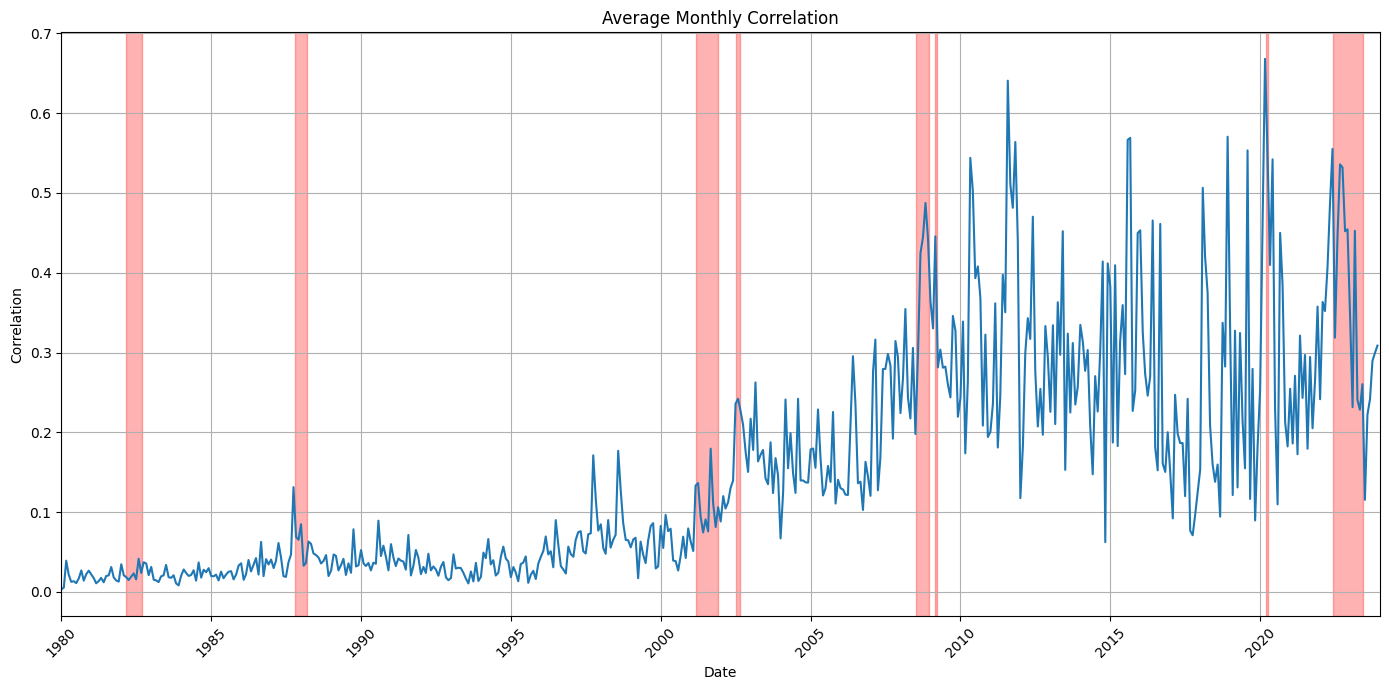

In [86]:
# Adding columns for Year and Month to perfrom groupby()
sp500 = data
sp500.insert(1, "Year", sp500['Date'].dt.year)
sp500.insert(2,"Month",sp500['Date'].dt.month)
grouped_data = sp500.groupby(['Year', 'Month'])
grouped_data_dict = dict(list(grouped_data))

# Calculates correlation between all stocks with eachother for each month for every year in the dataset
corr_agg = {}
for i in range (1980,2024):
    for j in range(1,13):
        df_i= grouped_data_dict[i,j].iloc[:,3:-1].corr()
        df_name = f'{i},{j}'
        corr_agg[df_name] = df_i
        corr_agg[df_name].reset_index(drop=True)
        df_i

# Extracting upper right triangle containing all the pairwise correlation
pairwise_corr_dict = {}
for year in range(1980, 2024):
    for month in range(1, 13):
        pairwise_corr_list = []
        for i in range(len(corr_agg[f'{year},{month}'])):
            pqr = corr_agg[f'{year},{month}'].iloc[i, (i+1):].reset_index(drop=True)
            pqr_name = f'{year}_{month}_{i}'  # Construct unique column name
            pqr.name = pqr_name
            pairwise_corr_list.append(pqr)
        pairwise_corr_dict[(year, month)] = pd.concat(pairwise_corr_list, axis=1)

# Creating a function to calculate the average monthly correlation of all the pairwsie correlation
def corr(year, month):
    correlation_value = (pairwise_corr_dict[(year, month)].sum()).sum() / ((503 * 502) / 2)
    date_string = f"{year}-{month:02d}"
    return pd.DataFrame([[date_string, correlation_value]])

# Creating a dataframe to store the average monthly correlation
monthly_corr = []
for year in range(1980, 2024):
    for month in range(1, 13):
        monthly_corr.append(corr(year, month))
monthly_corr_df = pd.concat(monthly_corr, ignore_index=True)

# Ploting the average monthly correlation
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(monthly_corr_df[0]), monthly_corr_df[1])
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Average Monthly Correlation')
plt.xlim(pd.Timestamp('1980'), pd.Timestamp('2024'))

for start, end in phases_df.iterrows():
    plt.axvspan(end['Start Date'], end['End Date'], color='red', alpha=0.3)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In the above, we have measured the average piecewise correlations each month from 1980 to 2023. Even this graph, shows that the average correlation is not remotely close to 1. The highest being during 2020 crash.

Therefore, from the above findings, we can say that correlation goes to one during crisis is not emperically supported by any type of test.

**CAPM Beta**

In [87]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ff = pd.DataFrame(pdr.DataReader(name='F-F_Research_Data_Factors_daily', data_source='famafrench', start='1900')[0].div(100))

ff = ff.reset_index()
ff = ff.drop(columns = ['Mkt-RF','SMB','HML'])
print(ff.dtypes)
print(ff.columns)

ff['Date'] = pd.to_datetime(ff['Date'])

#Filtering to ensure dates of Rf match
adjusted_bear_market_dfs = {}

for key, bear_df in bear_market_dfs.items():
    merged_ff = bear_df.merge(ff, on='Date', how='inner')

    stock_columns = merged_ff.columns.difference(['Date', 'RF_y'])
    for column in stock_columns:
      merged_ff[column] = merged_ff[column] - merged_ff['RF_y']

    merged_ff.drop('RF_y', axis=1, inplace=True)

    adjusted_bear_market_dfs[key] = merged_ff

#Calculating the betas
beta_dfs = []

# Iterate over each adjusted bear market DataFrame
for key, ff in adjusted_bear_market_dfs.items():
    stock_betas = {}
    for stock in ff.columns.difference(['Date', '% ^GSPC']):
        if ff[stock].isna().all():
            continue
        X = ff['% ^GSPC'].values.reshape(-1, 1)
        y = ff[stock].values

        model = LinearRegression().fit(X[np.isfinite(y)], y[np.isfinite(y)])

        stock_betas[stock] = model.coef_[0]

    # Construct DataFrame for current bear market phase
    beta_df = pd.DataFrame.from_dict(stock_betas, orient='index', columns=[f'{key}_beta'])
    beta_dfs.append(beta_df)

# Concatenate all DataFrames into a single DataFrame
final_beta_df = pd.concat(beta_dfs, axis=1)

Date    datetime64[ns]
RF             float64
dtype: object
Index(['Date', 'RF'], dtype='object')


In [88]:
# Print the DataFrame stats
final_beta_df

,1982-02-22 to 1982-09-14_beta,1987-10-19 to 1988-03-08_beta,2001-03-12 to 2001-12-05_beta,2002-07-10 to 2002-08-22_beta,2008-07-09 to 2008-12-08_beta,2009-02-23 to 2009-03-23_beta,2020-03-12 to 2020-04-08_beta,2022-06-13 to 2023-06-08_beta
AAPL,1.744035,1.490084,1.605124,0.796077,0.966307,0.830144,1.045660,1.272631
ABT,1.015920,0.656545,0.392885,0.847884,0.506965,0.556776,0.902863,0.801603
ADI,0.934746,0.809453,2.440541,1.349426,0.808932,0.777002,1.185798,1.241734
ADM,0.686769,0.964752,0.559883,0.451774,1.175492,0.778557,0.915207,0.644907
ADP,0.921606,1.140854,0.941688,0.759961,0.812919,0.682426,1.234849,0.957244
...,...,...,...,...,...,...,...,...
ZTS,NaN,NaN,NaN,NaN,NaN,NaN,1.040536,0.996966
ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.602069
CEG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.945404
GEHC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.956905


The above table shows the beta for a stock during a particular bear market phase

In [89]:
final_beta_df.describe()

,1982-02-22 to 1982-09-14_beta,1987-10-19 to 1988-03-08_beta,2001-03-12 to 2001-12-05_beta,2002-07-10 to 2002-08-22_beta,2008-07-09 to 2008-12-08_beta,2009-02-23 to 2009-03-23_beta,2020-03-12 to 2020-04-08_beta,2022-06-13 to 2023-06-08_beta
count,196.000000,240.000000,382.000000,386.000000,434.000000,434.000000,498.000000,502.000000
mean,0.727944,0.791367,0.896274,0.873173,1.031292,1.196604,1.066609,0.977944
std,0.434593,0.366434,0.612289,0.422960,0.361610,0.649017,0.301618,0.347457
min,-0.163510,-1.014030,-0.502318,-0.114354,0.313879,-0.093780,-0.450344,0.209378
25%,0.423656,0.577922,0.429532,0.668829,0.771511,0.757375,0.890507,0.743740
50%,0.715551,0.780501,0.789708,0.847668,0.959882,1.045013,1.068157,0.969140
75%,0.980471,1.051494,1.157841,1.030750,1.263709,1.478853,1.242541,1.179051
max,2.079673,1.781581,3.065599,5.898807,2.570146,3.970954,2.247373,2.298801


From the above, we can see that the average beta of all stocks is from 0.72 to 1.1 during any of these crisis. There is high volatality in all crisis, with the worst during the housing crash.
The least beta is -1.01 during the 1987 crash and the highest beta is 5.89 during the tech bubble 2002 crash.

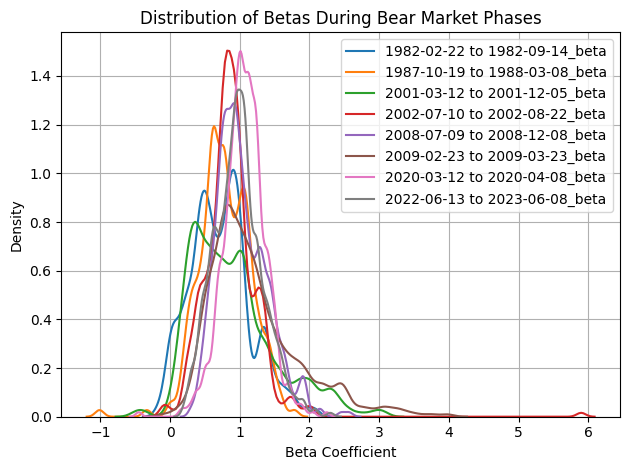

In [90]:
# Iterate through the corr_index and plot each phase's KDE on the same figure
for i in range(len(phases_df)):
    sns.kdeplot(data=final_beta_df.iloc[:, i], bw_adjust=0.5, label=final_beta_df.columns[i])

# Add labels and title
plt.xlabel('Beta Coefficient')
plt.ylabel('Density')
plt.title('Distribution of Betas During Bear Market Phases')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust the layout to make room for the elements
plt.show()

From the above denisty plot we can see that on average beta in the market is centered around 1, during all the crises, with the highest being in 2002 and 2020.

Therefore, from the above, we can conclude that CAPM Beta goes to 1 during crises is more emperically supported. We can make more studies into this.